<a href="https://colab.research.google.com/github/yazmyrad/rl_project/blob/main/PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import gym
import matplotlib.pyplot as plt

In [15]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
            np.array(self.actions),\
            np.array(self.probs),\
            np.array(self.vals),\
            np.array(self.rewards),\
            np.array(self.dones),\
            batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

class ActorNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256):
        super(ActorNetwork, self).__init__()

        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.fc3 = Dense(n_actions, activation='softmax')

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims=256, fc2_dims=256):
        super(CriticNetwork, self).__init__()
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        q = self.q(x)

        return q

In [18]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003,
                 gae_lambda=0.95, policy_clip=0.2, batch_size=64,
                 n_epochs=10, chkpt_dir='models/'):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.chkpt_dir = chkpt_dir

        self.actor = ActorNetwork(n_actions)
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic = CriticNetwork()
        self.critic.compile(optimizer=Adam(learning_rate=alpha))
        self.memory = PPOMemory(batch_size)

    def store_transition(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save(self.chkpt_dir + 'actor')
        self.critic.save(self.chkpt_dir + 'critic')

    def load_models(self):
        print('... loading models ...')
        self.actor = keras.models.load_model(self.chkpt_dir + 'actor')
        self.critic = keras.models.load_model(self.chkpt_dir + 'critic')

    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])

        probs = self.actor(state)
        dist = tfp.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = self.critic(state)

        action = action.numpy()[0]
        value = value.numpy()[0]
        log_prob = log_prob.numpy()[0]

        return action, log_prob, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
                reward_arr, dones_arr, batches = \
                self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1] * (
                        1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t

            for batch in batches:
                with tf.GradientTape(persistent=True) as tape:
                    states = tf.convert_to_tensor(state_arr[batch])
                    old_probs = tf.convert_to_tensor(old_prob_arr[batch])
                    actions = tf.convert_to_tensor(action_arr[batch])

                    probs = self.actor(states)
                    dist = tfp.distributions.Categorical(probs)
                    new_probs = dist.log_prob(actions)

                    critic_value = self.critic(states)

                    critic_value = tf.squeeze(critic_value, 1)

                    prob_ratio = tf.math.exp(new_probs - old_probs)
                    weighted_probs = advantage[batch] * prob_ratio
                    clipped_probs = tf.clip_by_value(prob_ratio,
                                                     1-self.policy_clip,
                                                     1+self.policy_clip)
                    weighted_clipped_probs = clipped_probs * advantage[batch]
                    actor_loss = -tf.math.minimum(weighted_probs,
                                                  weighted_clipped_probs)
                    actor_loss = tf.math.reduce_mean(actor_loss)

                    returns = advantage[batch] + values[batch]
                    # critic_loss = tf.math.reduce_mean(tf.math.pow(
                    #                                  returns-critic_value, 2))
                    critic_loss = keras.losses.MSE(critic_value, returns)

                actor_params = self.actor.trainable_variables
                actor_grads = tape.gradient(actor_loss, actor_params)
                critic_params = self.critic.trainable_variables
                critic_grads = tape.gradient(critic_loss, critic_params)
                self.actor.optimizer.apply_gradients(
                        zip(actor_grads, actor_params))
                self.critic.optimizer.apply_gradients(
                        zip(critic_grads, critic_params))

        self.memory.clear_memory()

In [19]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


... saving models ...
episode 0 score 34.0 avg score 34.0 time_steps 34 learning_steps 1
episode 1 score 20.0 avg score 27.0 time_steps 54 learning_steps 2
episode 2 score 13.0 avg score 22.3 time_steps 67 learning_steps 3
episode 3 score 14.0 avg score 20.2 time_steps 81 learning_steps 4
episode 4 score 17.0 avg score 19.6 time_steps 98 learning_steps 4
episode 5 score 23.0 avg score 20.2 time_steps 121 learning_steps 6
episode 6 score 14.0 avg score 19.3 time_steps 135 learning_steps 6
episode 7 score 44.0 avg score 22.4 time_steps 179 learning_steps 8
episode 8 score 24.0 avg score 22.6 time_steps 203 learning_steps 10
episode 9 score 18.0 avg score 22.1 time_steps 221 learning_steps 11
episode 10 score 35.0 avg score 23.3 time_steps 256 learning_steps 12
episode 11 score 22.0 avg score 23.2 time_steps 278 learning_steps 13
episode 12 score 14.0 avg score 22.5 time_steps 292 learning_steps 14
episode 13 score 27.0 avg score 22.8 time_steps 319 learning_steps 15
episode 14 score 16.0

FileNotFoundError: ignored

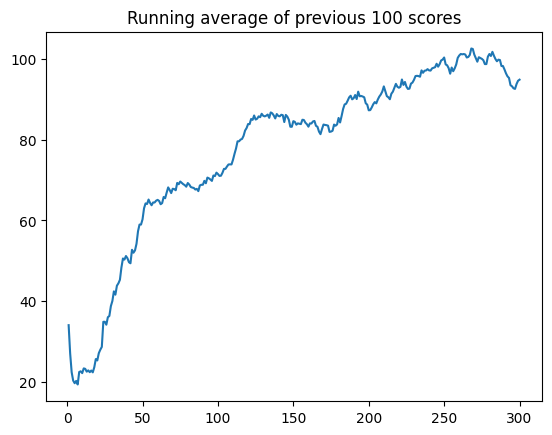

In [20]:
if __name__ == '__main__':
    env = gym.make('CartPole-v0')
    N = 20
    batch_size = 5
    n_epochs = 4
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
                  alpha=alpha, n_epochs=n_epochs,
                  input_dims=env.observation_space.shape)
    n_games = 300

    figure_file = 'plots/cartpole.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.store_transition(observation, action,
                                   prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
              'time_steps', n_steps, 'learning_steps', learn_iters)
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)